# Graph on BFS

test script to try bulding a graph on top of the face heads

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.ref_feature_map_neurons import ref_feature_map_neuron
from utils.calculate_position import calculate_position
from plots_utils.plot_cnn_output import plot_cnn_output
from plots_utils.plot_ft_map_pos import plot_ft_map_pos
from plots_utils.plot_ft_map_pos import plot_pos_on_images
from plots_utils.plot_tuning_signatures import plot_tuning_signatures
from models.NormBase import NormBase
from utils.patches import compute_center_of_activity

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

# Set parameters

In [2]:
# define configuration
config_path = 'GR_t02_graph_on_BFS_m0001.json'

# declare parameters
best_eyebrow_IoU_ft = [68, 125]
best_lips_IoU_ft = [235, 203, 68, 125, 3, 181, 197, 2, 87, 240, 6, 95, 60, 157, 227, 111]

# load config
config = load_config(config_path, path='../../configs/graph')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

# load extraction pipeline

In [3]:
# load and define model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

2022-04-26 20:25:40.657612: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-26 20:25:40.682341: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f82ea2e9030 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-26 20:25:40.682369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


# load data

In [4]:
data = load_data(config)
print("[LOAD] Data loaded", np.shape(data[0]))
print()

100%|██████████| 3/3 [00:00<00:00, 56.96it/s]

[LOAD] Data loaded (3, 224, 224, 3)



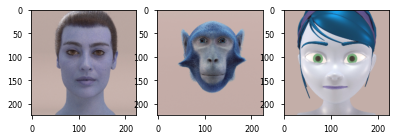

In [23]:
# plot images
plt.figure()
plt.subplot(1, 3, 1)
img1 = np.array(data[0][0] + 128)/256
img2 = np.array(data[0][1] + 128)/256
img3 = np.array(data[0][2] + 128)/256
img3[img3 > 1] = 1.0
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)

# predict with extraction pipeline

In [24]:
# predict
preds = v4_model.predict(data[0], verbose=1)
print("[TRAIN] shape prediction", np.shape(preds))

# get feature maps that mimic a semantic selection pipeline
# keep only highest IoU semantic score
eyebrow_preds = preds[..., best_eyebrow_IoU_ft]
print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
lips_preds = preds[..., best_lips_IoU_ft]
print("shape lips semantic feature selection", np.shape(lips_preds))
preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
print("[TRAIN] shape preds", np.shape(preds))

3/3 [==============================] - 0s 133ms/sample
[TRAIN] shape prediction (3, 56, 56, 256)
shape eyebrow semantic feature selection (3, 56, 56, 2)
shape lips semantic feature selection (3, 56, 56, 16)
[TRAIN] shape preds (3, 56, 56, 18)


# build RBF

In [163]:
rbf_template_hum = np.array([[[22, 25], [19, 22]], [[22, 25], [34, 37]], [[30, 33], [26, 31]]])  # louise
config['rbf_sigma'] = [3000, 3000, 2000]
patterns_hum = PatternFeatureSelection(config, template=rbf_template_hum)
rbf_template_monk = np.array([[[16, 19], [22, 25]], [[16, 19], [31, 34]], [[26, 29], [26, 31]]]) # Monkey
config['rbf_sigma'] = [2000, 2000, 2000]
patterns_monk = PatternFeatureSelection(config, template=rbf_template_monk)
rbf_template_cart = np.array([[[24, 27], [16, 19]], [[24, 27], [35, 38]], [[36, 39], [24, 29]]])  # Merry
config['rbf_sigma'] = [3000, 3000, 2000]
patterns_cart = PatternFeatureSelection(config, template=rbf_template_cart)

rbf_templates = [rbf_template_hum, rbf_template_monk, rbf_template_cart]
patterns = [patterns_hum, patterns_monk, patterns_cart]

shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)


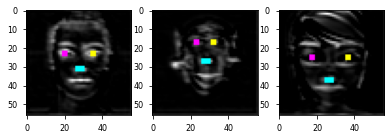

In [164]:
# show RBF on face
plt.figure()
for i in range(3):
    img = preds[i, ..., 0]
    img_norm = img / np.amax(img)
    img_norm = np.repeat(np.expand_dims(img_norm, axis=2), 3, axis=2)
    print("shape img_norm", np.shape(img_norm))

    img_norm[rbf_templates[i][0, 0, 0]:rbf_templates[i][0, 0, 1], rbf_templates[i][0, 1, 0]:rbf_templates[i][0, 1, 1]] = [1, 0, 1]
    img_norm[rbf_templates[i][1, 0, 0]:rbf_templates[i][1, 0, 1], rbf_templates[i][1, 1, 0]:rbf_templates[i][1, 1, 1]] = [1, 1, 0]
    img_norm[rbf_templates[i][2, 0, 0]:rbf_templates[i][2, 0, 1], rbf_templates[i][2, 1, 0]:rbf_templates[i][2, 1, 1]] = [0, 1, 1]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_norm, cmap='viridis')

# fit template

In [165]:
# fit templates
templates = []
for i in range(3):
    # template = patterns.fit(mask_template)
    _preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[i]), axis=0)
    print("shape template preds", np.shape(template_preds))
    template = patterns[i].fit(template_preds)
    template[template < 0.25] = 0
    print("shape template", np.shape(template), np.amin(template), np.amax(template))
    templates.append(template)
print("shape templates", np.shape(templates))
templates = np.concatenate((templates[0], templates[1], templates[2]), axis=3)
print("shape templates", np.shape(templates))

shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3) 0.0 1.0
shape templates (3, 1, 56, 56, 3)
shape templates (1, 56, 56, 9)


0 min max 0.0 1.0
1 min max 0.0 1.0
2 min max 0.0 1.0
3 min max 0.0 1.0
4 min max 0.0 1.0
5 min max 0.0 1.0
6 min max 0.0 1.0
7 min max 0.0 1.0
8 min max 0.0 1.0


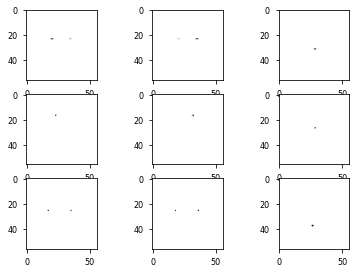

In [166]:
# plot template
plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        _template = templates[0, ..., i * 3 + j]
        print(i * 3 + j, "min max", np.amin(_template), np.amax(_template))
        plt.imshow(_template, cmap='Greys')

# get patches

In [167]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [168]:
# test function pred_to_patch
patches = pred_to_patch(templates[0, ..., 0])
print("shape patches", np.shape(patches))

shape patches (1, 7, 7, 64)


In [169]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [170]:
# test function get_patches_centers
centers, max_patch = get_patches_centers(patches)
print("shape centers", np.shape(centers))
print("max_patch", max_patch)

shape centers (2, 2)
max_patch [1.0, 0.4039647341998409]


# Get activity from patches

In [176]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.25):
    print("shape preds", np.shape(preds))
    print("shape patterns", np.shape(patterns))
    print("shape rbf_templates", np.shape(rbf_templates))
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds)
        template[template < threshold_val] = 0
        print("shape template", np.shape(template))

        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(template[0, ..., 0], cmap='Greys')
        plt.subplot(1, 3, 2)
        plt.imshow(template[0, ..., 1], cmap='Greys')
        plt.subplot(1, 3, 3)
        plt.imshow(template[0, ..., 2], cmap='Greys')

        templates.append(template)

    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

shape preds (56, 56, 18)
shape patterns (3,)
shape rbf_templates (3, 3, 2, 2)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
shape preds (56, 56, 18)
shape patterns (3,)
shape rbf_templates (3, 3, 2, 2)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
shape preds (56, 56, 18)
shape patterns (3,)
shape rbf_templates (3, 3, 2, 2)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
shape template (1, 56, 56, 3)
[PATTERN] Transform Pattern
[P

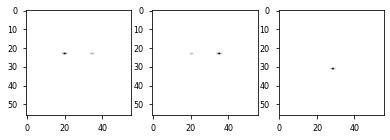

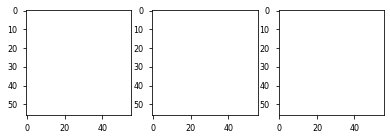

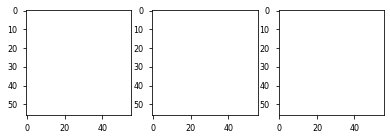

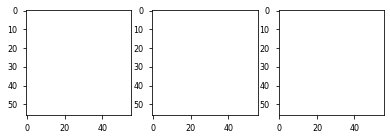

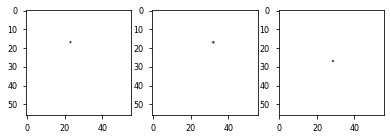

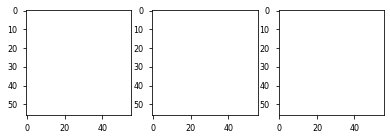

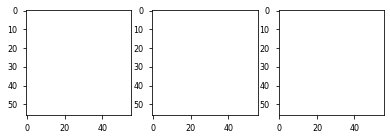

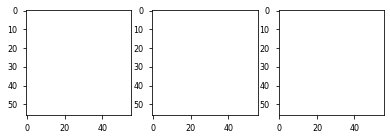

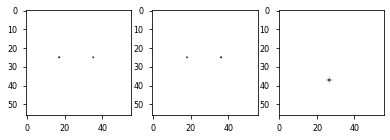

In [181]:
activities_dict = []
for i in range(3):
    activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates)
    activities_dict.append(activity_dict)

In [184]:
# display activities
for i in range(3):
    activity_dict = activities_dict[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [19.966002766151703, 22.999975340016615], 'max': 1.0}
{'type': 0, 'pos': [34.47542658327545, 22.999941827169152], 'max': 0.4039647341998409}
{'type': 1, 'pos': [20.456198774328566, 22.999933469041206], 'max': 0.36614782593032746}
{'type': 1, 'pos': [34.98646352255619, 22.99997527961495], 'max': 1.0}
{'type': 2, 'pos': [27.955234898578958, 30.99997265928053], 'max': 1.0}

{'type': 3, 'pos': [22.999955200286717, 16.99999360004096], 'max': 1.0}
{'type': 4, 'pos': [30.999843511851697, 16.999977644550242], 'max': 0.2862772610062919}
{'type': 4, 'pos': [32.0, 17.215569349871163], 'max': 1.0}
{'type': 5, 'pos': [27.99997440016384, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
{'type': 6, 'pos': [34.999977561079135, 24.99999252035971], 'max': 0.8556497216827943}
{'type': 7, 'pos': [17.999985342902725, 24.999992671451363], 'max': 0.8732906629251402}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.

In [178]:
def max_pool_activity(activity_dict, dist_threshold=3, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [185]:
activities_dict_max_pooled = []
for i in range(3):
    activity_dict = max_pool_activity(activities_dict[i])
    activities_dict_max_pooled.append(activity_dict)

In [186]:
# display activities
for i in range(3):
    activity_dict = activities_dict_max_pooled[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [19.966002766151703, 22.999975340016615], 'max': 1.0}
{'type': 1, 'pos': [34.98646352255619, 22.99997527961495], 'max': 1.0}
{'type': 2, 'pos': [27.955234898578958, 30.99997265928053], 'max': 1.0}

{'type': 3, 'pos': [22.999955200286717, 16.99999360004096], 'max': 1.0}
{'type': 4, 'pos': [32.0, 17.215569349871163], 'max': 1.0}
{'type': 5, 'pos': [27.99997440016384, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
{'type': 8, 'pos': [25.99452500476491, 37.027382103086296], 'max': 1.0}



# Get Type from activity

In [192]:
def get_type(activity_dict):
    types = [0, 0, 0]  # hum_type, monk_type, cart_type
    positions = []

    for i in activity_dict:
        print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            types[0] += 1
        elif dict['type'] in [3, 4, 5]:
            types[1] += 1
        elif dict['type'] in [6, 7, 8]:
            types[2] += 1

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

    print(types)
    print(positions)
    print()
    
    bfs_type = np.argmax(types)
    print("bfs_type", bfs_type)
    mean_pos = np.mean(positions, axis=0)
    print("mean_pos", mean_pos)
    width = left_eye_pos[0] - right_eye_pos[0]
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])
    print(width, height)

In [193]:
get_type(activities_dict_max_pooled[0])

{'type': 0, 'pos': [19.966002766151703, 22.999975340016615], 'max': 1.0}
{'type': 1, 'pos': [34.98646352255619, 22.99997527961495], 'max': 1.0}
{'type': 2, 'pos': [27.955234898578958, 30.99997265928053], 'max': 1.0}
[3, 0, 0]
[[19.966002766151703, 22.999975340016615], [34.98646352255619, 22.99997527961495], [27.955234898578958, 30.99997265928053]]
bfs_type 0
mean_pos [27.636 25.667]
15.02046075640449 7.9999973796655794
